# Seer-py Example
This workbook runs through a brief example of how to use the seer-py library to interact directly with the seer database to view what data exists, download raw data, and upload new labels.

Firstly, we need to load in seer-py as well as data-handling tools numpy and pandas

In [1]:
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize

In [2]:
import seerpy
from seerpy.plotting import seerPlot

## Client
Now that we have the libraries loaded, we want to interact with the database. To do this, we need to create a client. The client handles the connection to the database as well as user crendentials. `createClient()` will prompt user for a username and password, and verify these credentials with the database.

In [4]:
client = seerpy.SeerConnect()

Email Adddress: staff1@seermail.com
Password: ········
Login Successful


## Metadata
Next, we want to see all the data that is available. This is handled by `createMetaData` which will query the database to see everything that is available to the user, and return a list of pandas DataFrames. These dataframes will then be used to download data.

In [5]:
allData, channelGroups, segments, channels, dataChunks, labelGroups, labels = client.createMetaData()
# OR equivalently:
# allData = client.createMetaData()[0]

studyId = 'study2'
allData = allData[allData['id']==studyId]
allData.head()

study query time:  1.18
study query time:  3.23
study query time:  0.52
study query time:  0.8
study query time:  0.93
study query time:  0.81
study query time:  1.21
study query time:  2.22


,id,name,patient,patient.id,channelGroups.chunkPeriod,channelGroups.exponent,channelGroups.id,channelGroups.name,channelGroups.recordLength,channelGroups.recordsPerChunk,...,segments.duration,segments.id,segments.startTime,dataChunks.length,dataChunks.time,dataChunks.url,channels.channelType.category,channels.channelType.name,channels.id,channels.name
3314,study2,Study 2,NaN,NaN,10,-3,scg3,ECG,1,10,...,507000.0,cg-seg3,1.506649e+12,10000.0,1.506649e+12,https://d2s3l5j4dzhlu.cloudfront.net/cg-seg3_0...,ecg,ECG,8b68ea43-70c8-499a-9fd8-51f7701517b3,None
3315,study2,Study 2,NaN,NaN,10,-3,scg3,ECG,1,10,...,507000.0,cg-seg3,1.506649e+12,10000.0,1.506649e+12,https://d2s3l5j4dzhlu.cloudfront.net/cg-seg3_0...,ecg,ECG,8b68ea43-70c8-499a-9fd8-51f7701517b3,None
3316,study2,Study 2,NaN,NaN,10,-3,scg3,ECG,1,10,...,507000.0,cg-seg3,1.506649e+12,10000.0,1.506649e+12,https://d2s3l5j4dzhlu.cloudfront.net/cg-seg3_0...,ecg,ECG,8b68ea43-70c8-499a-9fd8-51f7701517b3,None
3317,study2,Study 2,NaN,NaN,10,-3,scg3,ECG,1,10,...,507000.0,cg-seg3,1.506649e+12,10000.0,1.506649e+12,https://d2s3l5j4dzhlu.cloudfront.net/cg-seg3_0...,ecg,ECG,8b68ea43-70c8-499a-9fd8-51f7701517b3,None
3318,study2,Study 2,NaN,NaN,10,-3,scg3,ECG,1,10,...,507000.0,cg-seg3,1.506649e+12,10000.0,1.506649e+12,https://d2s3l5j4dzhlu.cloudfront.net/cg-seg3_0...,ecg,ECG,8b68ea43-70c8-499a-9fd8-51f7701517b3,None


###  
Now that we have meta data, we can filter down to a specific study, patient, data type, etc. In this example, we want eeg data from Study 2, and we use pandas filtering methods to reduce `allData` down to the rows of interest

In [6]:
studyId = 'study2'
allData = allData[allData['id']==studyId]
allData = allData[allData['channelGroups.name'].str.contains('EEG')]
allData.head(5)

,id,name,patient,patient.id,channelGroups.chunkPeriod,channelGroups.exponent,channelGroups.id,channelGroups.name,channelGroups.recordLength,channelGroups.recordsPerChunk,...,segments.duration,segments.id,segments.startTime,dataChunks.length,dataChunks.time,dataChunks.url,channels.channelType.category,channels.channelType.name,channels.id,channels.name
3365,study2,Study 2,NaN,NaN,10,-6,scg2,EEG,1,10,...,507000.0,cg-seg4,1.506649e+12,10000.0,1.506649e+12,https://d2s3l5j4dzhlu.cloudfront.net/cg-seg4_0...,eeg,Fp1,e14499b5-d4ca-4784-8ac9-503f5fe883d4,None
3366,study2,Study 2,NaN,NaN,10,-6,scg2,EEG,1,10,...,507000.0,cg-seg4,1.506649e+12,10000.0,1.506649e+12,https://d2s3l5j4dzhlu.cloudfront.net/cg-seg4_0...,eeg,Fp2,41a6fd6e-d410-41b0-8023-2c650e9be427,None
3367,study2,Study 2,NaN,NaN,10,-6,scg2,EEG,1,10,...,507000.0,cg-seg4,1.506649e+12,10000.0,1.506649e+12,https://d2s3l5j4dzhlu.cloudfront.net/cg-seg4_0...,eeg,F3,9e6138f8-963f-4f62-95e6-9ae2a2325e7e,None
3368,study2,Study 2,NaN,NaN,10,-6,scg2,EEG,1,10,...,507000.0,cg-seg4,1.506649e+12,10000.0,1.506649e+12,https://d2s3l5j4dzhlu.cloudfront.net/cg-seg4_0...,eeg,F4,dd5cbf9c-b76b-4671-af43-c28e0ef1d316,None
3369,study2,Study 2,NaN,NaN,10,-6,scg2,EEG,1,10,...,507000.0,cg-seg4,1.506649e+12,10000.0,1.506649e+12,https://d2s3l5j4dzhlu.cloudfront.net/cg-seg4_0...,eeg,C3,efad27ef-3223-4030-a629-428aa7dc20cd,None


###  
`getLinks` takes a pandas dataframe (as given by `createMetaData`) and downloads raw data, returning another dataframe with raw data, a timestamp, and study metadata, such as id, channelGroup, and segment 

In [7]:
data = client.getLinks(allData.copy())
data.head()

,time,id,channelGroups.id,segments.id,Channel 0,Channel 1,Channel 2,Channel 3,Channel 4,Channel 5,...,Channel 13,Channel 14,Channel 15,Channel 16,Channel 17,Channel 18,Channel 19,Channel 20,Channel 21,Channel 22
0,1.506649e+12,study2,scg2,cg-seg4,10000.076172,10000.076172,10000.076172,10000.076172,10000.076172,10000.076172,...,10000.076172,10000.076172,10000.076172,10000.076172,10000.076172,10000.076172,10000.076172,10000.076172,10000.076172,10000.076172
1,1.506649e+12,study2,scg2,cg-seg4,9997.787109,10000.380859,9973.983398,10009.384766,9996.718750,10002.060547,...,10023.269531,9958.266602,9994.736328,9945.143555,10014.572266,10000.534180,10005.263672,9984.054688,10000.076172,10000.076172
2,1.506649e+12,study2,scg2,cg-seg4,10017.318359,10060.044922,9986.343750,10031.205078,9991.074219,10022.048828,...,10009.384766,9975.204102,9990.615234,9959.792969,10066.300781,10016.097656,10013.046875,9982.681641,10000.076172,10000.076172
3,1.506649e+12,study2,scg2,cg-seg4,10004.501953,10041.427734,9992.751953,10033.188477,9997.939453,10024.795898,...,10097.734375,9989.700195,9957.960938,9946.669922,10016.861328,10020.066406,10011.214844,9973.525391,10000.076172,10000.076172
4,1.506649e+12,study2,scg2,cg-seg4,10007.552734,10027.084961,9980.697266,10017.318359,9996.872070,10019.607422,...,10094.987305,9976.272461,9966.353516,9936.446289,10025.253906,10012.283203,10010.299805,9972.000000,10000.076172,10000.076172


####  
To see what we are actually looking at, lets make a plot. `seerPlot` is a simple function to plot either a pandas dataframe or numpy array.

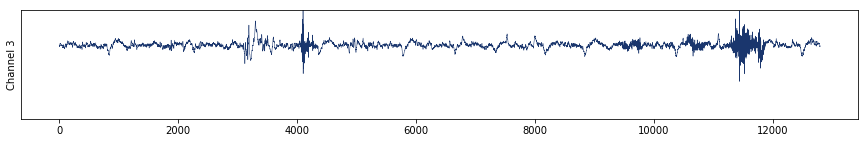

In [9]:
start = 0
end = 12800
seerPlot(x=data.iloc[start:end, 7], figSize=(15,2))

####  
Now we want to create a new label group, and if it exists, we will delete and re-create it.
`delLabelGroup` will delete a label group given a labelGroupId
`addLabelGroup` will create a new labelGroup given studyId, labelTypeId, labelGroupName, labelGroupDescription

In [10]:
labelGroupName = 'testname1'
labelGroupDescription = 'testDescription'
if len(allData[(labelGroups['labelGroups.name']==labelGroupName) & (allData['id']==studyId)])!=0:
    delLG = client.delLabelGroup(allData[(allData['labelGroups.name']==labelGroupName) & (allData['id']==studyId)]['labelGroups.id'].iloc[0])
labelGroup = client.addLabelGroup(studyId, labelGroupName, labelGroupDescription)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


Now we're ready to create our new label. In this example, we will highlight any areas where the amplitide is above 90% over a one second window. This could be used to highlight areas of extreme amplitude, which are potentially artifacts in the recording.
`alarm` is an array of start and finish times (millisecods since epoch) which have amplitude above 90%
The function `makeLabel` takes an array of ones and zeros (1 for true label and 0 for false) and creates a start time-finish time array.

In [11]:
dataNew = client.applyMovAvg(data.iloc[:,7].as_matrix(), 64)
alarmLabel = np.any(dataNew>np.percentile(dataNew, q=90), axis=1)
alarm = client.makeLabel(alarmLabel, data['time'].values)
print(alarm[:5, :])

[[  1.50664851e+12   1.50664851e+12]
 [  1.50664852e+12   1.50664852e+12]
 [  1.50664852e+12   1.50664852e+12]
 [  1.50664852e+12   1.50664852e+12]
 [  1.50664852e+12   1.50664852e+12]]


Now we can upload the labels to the Seer database with `addLabel`

In [12]:
for i in range(alarm.shape[0]):
    client.addLabel(labelGroup, alarm[i,0], alarm[i,1]-alarm[i,0], 11.0)

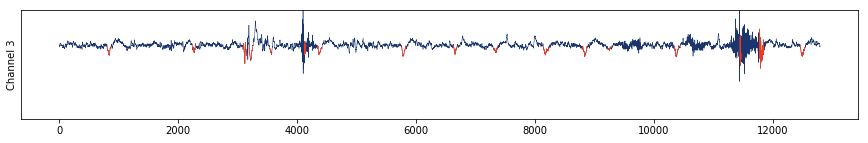

In [13]:
start = 0
end = 12800
seerPlot(x=data.iloc[start:end, 7], y=alarmLabel[start:end], figSize=(15,2))

## Getting more Information

If you're not sure how something works, try the function name, followed by '?' (e.g. seer.addLabel?), or help(function_name)

In [14]:
help(client.addLabel)

Help on method addLabel in module seerpy.seerpy:

addLabel(groupId, startTime, duration, timezone) method of seerpy.seerpy.SeerConnect instance
    Add label to label group
    
    Parameters
    ----------
    groupID : string
            Seer group ID
    startTime : float
            label start time in epoch time
    duration : float
            duration of event in milliseconds
    timezone : float
            local UTC timezone (eg. Melbourne = 11.0)
    
    Returns
    -------
    None
    
    Notes
    -----
    
    Example
    -------
    alarm = np.array([[1000, 200], [3000, 500], [5000, 400]])
    for i in range(alarm.shape[0]):
        addLabel(labelGroup, alarm[i,0], alarm[i,1]-alarm[i,0])

